# Logo Detection on Flickr27 Logo Dataset

In [139]:
import csv
import random
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import cv2
from keras.utils import np_utils
import glob

# Loading Dataset

In [140]:
txt_file = "flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt"
test_file = "flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt"
image_dir = "flickr_logos_27_dataset/flickr_logos_27_dataset_images/"
extra_img = "more_images/"

In [141]:
annot_train = np.loadtxt(txt_file, dtype='a')
annot_test = np.loadtxt(test_file, dtype='a')

# Processing Images
There is a lot of variation in size of images, all the images are resized to (224,224).

## challenges
If the images are resized then the co-ordinates of bounding needs to be adjusted, which is done by multiplying the ratio of new size to old size.

Test data has an extra class "none". So, I added some new images to training data which do not have logos from SUN 397 dataset with bounding box (0,0),(0,0).

In [142]:
def parse_annot(annot):
    fn = annot[0].decode('utf-8')
    class_name = annot[1].decode('utf-8')
    subset_class = annot[2].decode('utf-8')
    xmin = int(annot[3].decode('utf-8'))
    ymin = int(annot[4].decode('utf-8'))
    xmax = int(annot[5].decode('utf-8'))
    ymax = int(annot[6].decode('utf-8'))
    return fn, class_name, subset_class, xmin, ymin, xmax, ymax

def parse_test_resize(annot,new_size=(224,224)):
    fn = annot[0].decode('utf-8')
    class_name = annot[1].decode('utf-8')
    old_im=Image.open(image_dir+fn)
    old_size=old_im.size
    x_r = new_size[0]/old_size[0]
    y_r = new_size[1]/old_size[1]
    new_im = old_im.resize((new_size))
    return fn, new_im, class_name, x_r, y_r

def process_img_resize(annot, new_size=(224,224)):
    fn, class_name, subset_class, xmin, ymin, xmax, ymax = parse_annot(annot)
    old_im=Image.open(image_dir+fn)
    old_size=old_im.size
    x_r = new_size[0]/old_size[0]
    y_r = new_size[1]/old_size[1]
    new_im = old_im.resize((new_size))
    x1 = int(xmin*x_r)
    y1 = int(ymin*y_r)
    x2 = int(xmax*x_r)
    y2 = int(ymax*y_r)
    return new_im, x1, y1, x2, y2, class_name

def new_img_to_train(images,new_size=(224,224)):
    img = Image.open(images)
    img = img.resize(new_size)
    class_name = 'none'
    x1=0
    y1=0
    x2=0
    y2=0
    return img,class_name, x1,y1,x2,y2

# Creating a Evaluation Metrics

Accuracy of bounding boxes cannot be calculated directly, It is calculated by another formula "Intersection over Union (IOU)".

In [143]:
#Evaluation Function
def IntersectionOverUnion(box1,box2):
    xmin1,ymin1,xmax1,ymax1 = box1[0],box1[1],box1[2],box1[3]
    xmin2,ymin2,xmax2,ymax2 = box2[0],box2[1],box2[2],box2[3]
    w_I = min(xmax1,xmax2)-max(xmin1,xmin2)
    h_I = min(ymax1,ymax2)-max(ymin1,ymin2)
    if w_I <=0 or h_I <=0:
        return 0
    I=w_I *h_I
    U=(abs(xmax1-xmin1)*abs(ymax1-ymin1))+(abs(xmax2-xmin2)*abs(ymax2-ymin2))-I
    return I/U

In [144]:
images=[]
labels=[]
box_x1=[]
box_x2=[]
box_y1=[]
box_y2=[]

for annot in annot_train:
    new_im, x1, y1, x2, y2, class_name = process_img_resize(annot)
    images.append(new_im)
    labels.append(class_name)
    box_x1.append(x1)
    box_x2.append(x2)
    box_y1.append(y1)
    box_y2.append(y2)

for fn in glob.glob(extra_img+'/*.jpg'):
    img,class_name, x1,y1,x2,y2=new_img_to_train(fn)
    images.append(img)
    labels.append(class_name)
    box_x1.append(x1)
    box_x2.append(x2)
    box_y1.append(y1)
    box_y2.append(y2)

In [145]:
test_image=[]
test_labels=[]
x_shift=[]
y_shift=[]
for annot in annot_test:
    fn, new_im, class_name, x_, y_ = parse_test_resize(annot)
    test_image.append(new_im)
    test_labels.append(class_name)
    x_shift.append(x_)
    y_shift.append(y_)

In [146]:
data=pd.DataFrame(data={'image':images,'labels':labels,'x1':box_x1,'y1':box_y1,'x2':box_x2,'y2':box_y2})
data.head()

,image,labels,x1,x2,y1,y2
0,<PIL.Image.Image image mode=RGB size=224x224 a...,Adidas,30,187,12,151
1,<PIL.Image.Image image mode=RGB size=224x224 a...,Adidas,108,185,124,197
2,<PIL.Image.Image image mode=RGB size=224x224 a...,Adidas,28,191,12,151
3,<PIL.Image.Image image mode=RGB size=224x224 a...,Adidas,24,200,54,158
4,<PIL.Image.Image image mode=RGB size=224x224 a...,Adidas,37,58,28,41


In [147]:
test_data=pd.DataFrame(data={'image':test_image,'labels':test_labels,'x_shift':x_shift,'y_shift':y_shift})
test_data.head()

,image,labels,x_shift,y_shift
0,<PIL.Image.Image image mode=RGB size=224x224 a...,Adidas,0.448000,0.597333
1,<PIL.Image.Image image mode=RGB size=224x224 a...,Adidas,0.448000,0.454361
2,<PIL.Image.Image image mode=RGB size=224x224 a...,Adidas,0.527059,0.842105
3,<PIL.Image.Image image mode=RGB size=224x224 a...,Adidas,0.448000,0.597333
4,<PIL.Image.Image image mode=RGB size=224x224 a...,Adidas,0.700000,0.933333


In [148]:
del test_image, test_labels, x_shift, y_shift, images,labels,box_x1,box_x2,box_y1,box_y2

In [149]:
test_image = np.array([np.array(im) for im in test_data['image']])
test_image = test_image/255

In [150]:
images = np.array([np.array(im) for im in data['image']])

In [151]:
box=['x1','y1','x2','y2']
boxes = data[box].values

In [152]:
boxes.shape

(4616, 4)

# Create Model and Train 

In [153]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Dropout, Activation, Conv2D, MaxPooling2D, Lambda, Flatten
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import RMSprop, nadam, adam
from keras.applications.vgg16 import VGG16

In [154]:
def pre_trained_vgg():
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=images.shape[1:], classes=4)
    x = base_model.get_layer('block5_pool').output
    flat = Flatten()(x)
    FC_box = Dense(128, activation='relu')(flat)
    FC_box = Dropout(0.4)(FC_box)
    preds = Dense(4, activation='relu')(FC_box)
    model = Model(inputs=base_model.input,outputs=preds)
    model.compile(loss='mean_absolute_error',optimizer=adam(lr=0.0001))
    return model
def limit_mem():
    import keras.backend as K
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
    print('gpu memory cleaned')

In [155]:
model=pre_trained_vgg()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [156]:
from sklearn.model_selection import KFold
folds=KFold(n_splits=10, random_state=42, shuffle=True)
predict_te=np.zeros((len(test_image), 4))
predict=np.zeros((len(images), 4))
for train,test in folds.split(images,boxes):
    limit_mem()
    X_train, X_test = images[train], images[test]
    Y_train, Y_test = boxes[train], boxes[test]
    model=None
    model=pre_trained_vgg()
    hist=model.fit(X_train/255,Y_train, validation_data=(X_test/255, Y_test),epochs=2, batch_size=4,verbose=1)
    preds=model.predict(X_test/255,batch_size=4, verbose=1)
    predict_te +=model.predict(test_image/255,batch_size=4, verbose=1)
    predict +=model.predict(images/255,batch_size=4, verbose=1)
    IOU=0
    for actual,pred in zip(Y_test,preds):
        IOU+=IntersectionOverUnion(actual,pred)
    print("IOU score for this fold =",IOU/len(X_test))
    del hist, IOU

gpu memory cleaned
Train on 4154 samples, validate on 462 samples
Epoch 1/2
4154/4154 [==============================] - 257s 62ms/step - loss: 50.7152 - val_loss: 39.2993
Epoch 2/2
4616/4616 [==============================] - 105s 23ms/step
IOU score for this fold = 0.2461252518063149
gpu memory cleaned
Train on 4154 samples, validate on 462 samples
Epoch 1/2
4154/4154 [==============================] - 325s 78ms/step - loss: 49.5535 - val_loss: 39.9272
Epoch 2/2
4616/4616 [==============================] - 137s 30ms/step
IOU score for this fold = 0.2533766737317822
gpu memory cleaned
Train on 4154 samples, validate on 462 samples
Epoch 1/2
4154/4154 [==============================] - 303s 73ms/step - loss: 50.1941 - val_loss: 42.1629
Epoch 2/2
4616/4616 [==============================] - 86s 19ms/step
IOU score for this fold = 0.2702296383310868
gpu memory cleaned
Train on 4154 samples, validate on 462 samples
Epoch 1/2
4154/4154 [==============================] - 261s 63ms/step - lo

In [157]:
train_predictions = (np.trunc(predict/10)).astype(int)
test_predictions = (np.trunc(predict_te/10)).astype(int)

# Visualizing the results
## training data

train index 1933


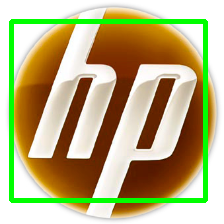

In [158]:
idx=random.choice(range(0,len(data['labels'])))
print("train index", idx)
fn, class_name, subset_class, xmin, ymin, xmax, ymax = parse_annot(annot_train[idx])
img=cv2.imread(image_dir+fn)
img=cv2.resize(img, (224, 224)) 
img = cv2.rectangle(img, (train_predictions[idx][0], train_predictions[idx][1]),(train_predictions[idx][2], train_predictions[idx][3]), (0, 255, 0), 3)
Image.fromarray(img)

train index 660


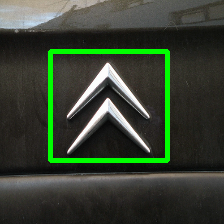

In [159]:
idx=random.choice(range(0,len(data['labels'])))
print("train index", idx)
fn, class_name, subset_class, xmin, ymin, xmax, ymax = parse_annot(annot_train[idx])
img=cv2.imread(image_dir+fn)
img=cv2.resize(img, (224, 224)) 
img = cv2.rectangle(img, (train_predictions[idx][0], train_predictions[idx][1]),(train_predictions[idx][2], train_predictions[idx][3]), (0, 255, 0), 3)
Image.fromarray(img)

## Test data

test index 68


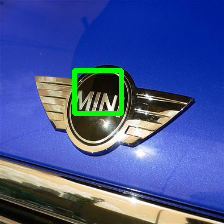

In [160]:
tst_idx = random.choice(range(0,len(test_data['labels'])))
print('test index',tst_idx)
fn, new_im, class_name, x_r, y_r = parse_test_resize(annot_test[tst_idx])
img=cv2.imread(image_dir+fn)
img=cv2.resize(img, (224, 224)) 
img = cv2.rectangle(img, (test_predictions[tst_idx][0], test_predictions[tst_idx][1]),(test_predictions[tst_idx][2], test_predictions[tst_idx][3]), (0, 255, 0), 3)
Image.fromarray(img)

test index 132


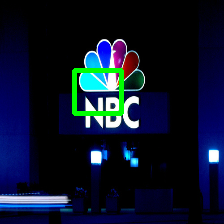

In [161]:
tst_idx = random.choice(range(0,len(test_data['labels'])))
print('test index',tst_idx)
fn, new_im, class_name, x_r, y_r = parse_test_resize(annot_test[tst_idx])
img=cv2.imread(image_dir+fn)
img=cv2.resize(img, (224, 224)) 
img = cv2.rectangle(img, (test_predictions[tst_idx][0], test_predictions[tst_idx][1]),(test_predictions[tst_idx][2], test_predictions[tst_idx][3]), (0, 255, 0), 3)
Image.fromarray(img)